# Explainable AI for Titanic Dataset

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import shap

shap.initjs()

### Data Dictionary
| Variable | Definition | Key |
| --- | --- | --- |
| survival | Survival | 0 = No, 1 = Yes |
|pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|Sex||
|Age|Age|in years|
|sibsp|# of siblings / spouses aboard the Titanic	||
|parch|# of parents / children aboard the Titanic||
|ticket|Ticket number||
|fare|Passenger fare	||
|cabin|Cabin number||
|embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|

In [2]:
seed_value=123456
# Change the path to your input dataset
train_input = "https://raw.githubusercontent.com/yptheangel/datasets/main/titanic/train.csv"
df_raw = pd.read_csv(train_input)
df_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Data quality check
df_raw.isnull().sum() # check nulls

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
#Preprocess
df = df_raw.copy()
df.columns = df.columns.str.lower()
#get age_group
# df["age"]=df["age"].fillna(-999)
df["age"]=df["age"].fillna(-1)

# cut_bins = [-1000, 0, 22, 33, 45,57,80]
cut_bins = [-2, 0, 22, 33, 45,57,80]

# cut_bins = [0, 22, 33, 45,57,80]

df["age_group"]=pd.cut(df["age"],bins=cut_bins)
# #standardize fare value
stdscaler = StandardScaler()
df["fare"] = stdscaler.fit_transform(df["fare"].values.reshape(-1, 1))
# label encode categorical features
ls_sex = ['male','female']
ls_age_group = ['(-2, 0]', '(0, 22]', '(22, 33]', '(33, 45]', '(45, 57]', '(57, 80]']
# ls_age_group = ['(-1000, 0]', '(0, 22]', '(22, 33]', '(33, 45]', '(45, 57]', '(57, 80]']

ls_embarked = ['S','C','Q']

df['sex'] = df['sex'].apply(lambda x: ls_sex.index(x))
df['age_group'] = df['age_group'].apply(str)
# df['age_group'] = df['age_group'].apply(lambda x: ls_age_group.index(x) if (x!="(-1000, 0]")  else -999)
df['age_group'] = df['age_group'].apply(lambda x: ls_age_group.index(x) if (x!="(-2, 0]")  else -1)

# df["embarked"]=df["embarked"].fillna(-999)
# df['embarked'] = df['embarked'].apply(lambda x: ls_embarked.index(x) if (x!=-999) else -999 )

df["embarked"]=df["embarked"].fillna(-1)
df['embarked'] = df['embarked'].apply(lambda x: ls_embarked.index(x) if (x!=-1) else -1 )



In [5]:
# features_columns = ["Pclass", "Sex", "SibSp", "Parch",""]
feature_set = ['pclass', 'sex', 'sibsp', 'parch', 'fare', 'embarked', 'age_group']
y = df["survived"]
X = df[feature_set]

# X = pd.get_dummies(df[features])
# X_test = pd.get_dummies(df[features])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed_value)

In [7]:
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 441, 1: 271})
Counter({0: 108, 1: 71})


In [8]:
model_type = "gbm"
# model_type = "rf"

if model_type == "rf": # Random Forest
    model = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=seed_value)
elif model_type == "gbm": # Gradient Boosted Trees (LightGBM)
    model = LGBMClassifier(learning_rate=0.1, n_estimators=1000, subsample=0.7, bagging_freq=5,
                           random_state=seed_value,
                           importance_type='gain')
else:
    model = None
    
model.fit(X_train, y_train)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


LGBMClassifier(bagging_freq=5, importance_type='gain', n_estimators=1000,
               random_state=123456, subsample=0.7)

In [9]:
## evaluation on test_set
print(model_type)
y_pred = model.predict(X_test)
print("accuracy: ",model.score(X_test,y_test))
print(classification_report(y_test, y_pred))

gbm
accuracy:  0.8268156424581006
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       108
           1       0.81      0.73      0.77        71

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



## Feature Importance

### framework in-built feature importance

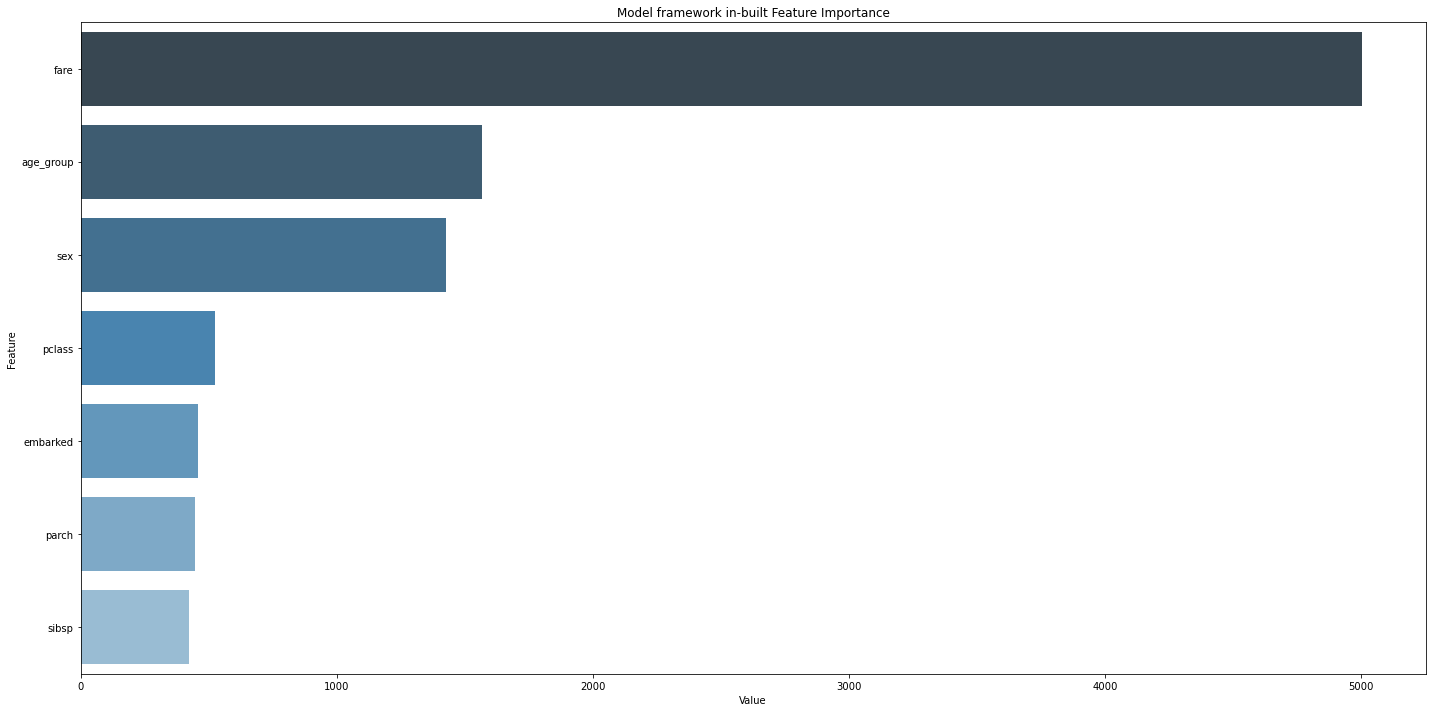

In [10]:
fi_df = pd.DataFrame(sorted(zip(X_train.columns,model.feature_importances_)), columns=['Feature','Value']).sort_values(by="Value", ascending=False)
# fi_df.to_csv("fi.csv",index=False) # export to csv
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=fi_df, palette="Blues_d")
plt.title('Model framework in-built Feature Importance')
plt.tight_layout()
plt.show()

### Permutation Importance

In [11]:
columns = X_train.columns.tolist()
pm = permutation_importance(model, X_train, y_train, random_state=seed_value)
output = [[columns[i], pm.importances_mean[i]] for i in range(len(columns))]
pi_df = pd.DataFrame(data=output, columns=['Feature', 'Importance_Mean']).sort_values('Importance_Mean', ascending=False)
# pi_df.to_csv("pi.csv",index=False) # export to csv

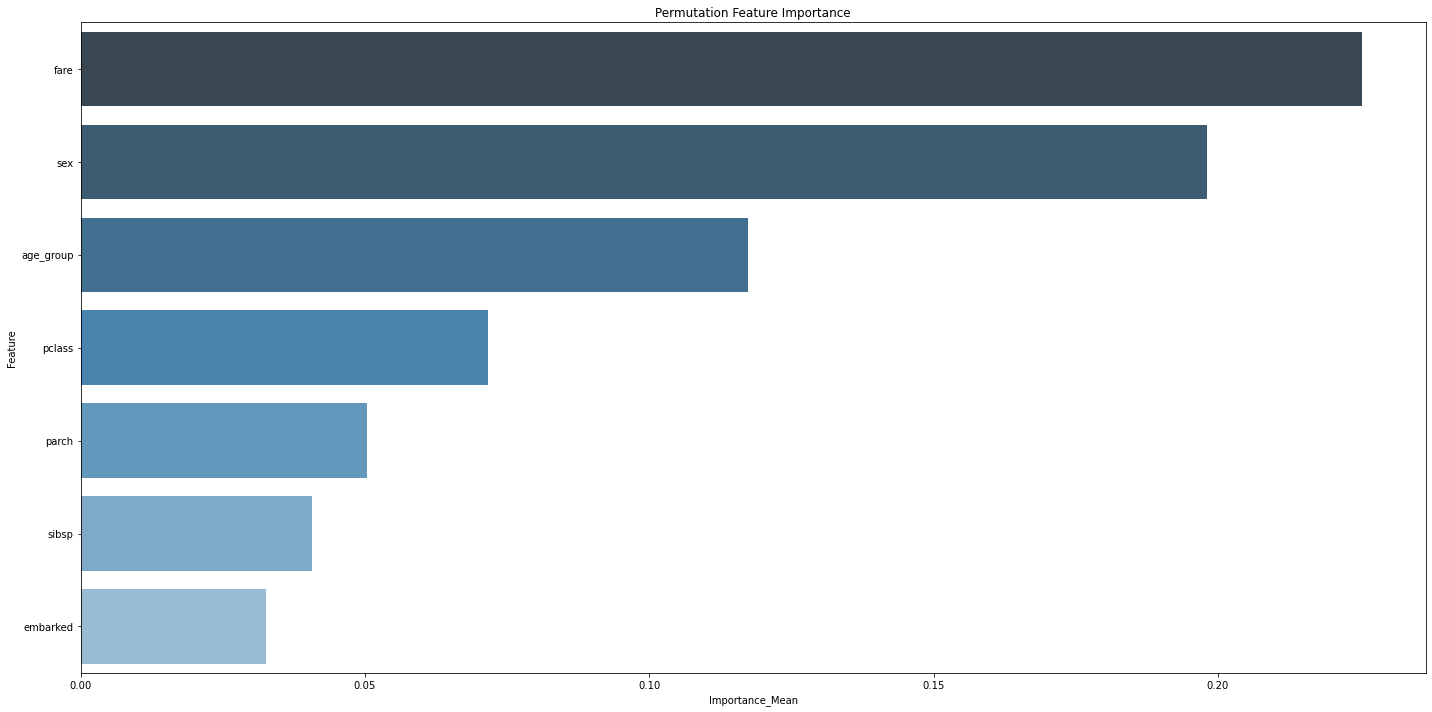

In [12]:
# fi_df.to_csv("fi.csv",index=False) # export to csv
plt.figure(figsize=(20, 10))
sns.barplot(x="Importance_Mean", y="Feature", data=pi_df, palette="Blues_d")
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()

## SHAP

In [13]:
%%time
X_split = X
if model_type in ["gbm","rf"]:
    explainer = shap.TreeExplainer(model=model, feature_perturbation="tree_path_dependent")
    shap_values = explainer.shap_values(X_split)

Wall time: 1.61 s


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


### Global

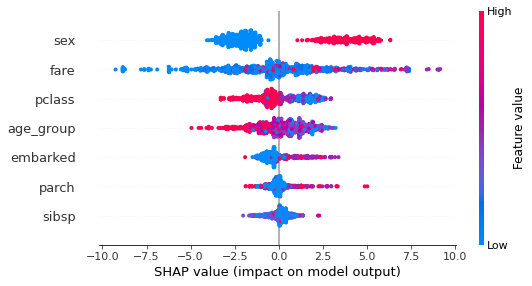

In [14]:
shap.summary_plot(shap_values[1], X_split, plot_type='dot', max_display=X_split.shape[1]) # if max_display if will default to top 20 features
# to export as image
# shap.summary_plot(shap_values[1], X,plot_type='dot',  max_display=X_split.shape[1], show=False)
# plt.savefig(f'shap_summary_plot_dot.png', bbox_inches='tight')

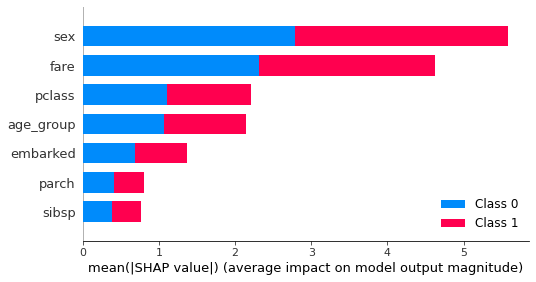

In [15]:
shap.summary_plot(shap_values, X_split)

### Local

In [16]:
row_index = random.randint(0,X_split.shape[0])
print("row_index: ",row_index)
# row_index = 494

shap.force_plot(base_value=explainer.expected_value[1],
                shap_values=shap_values[1][row_index,:],
                features=X_split.iloc[row_index,:])

row_index:  88


In [17]:
pname ="Petranec, Miss. Matilda"
row_index = df[df["name"]==pname].index[0]
print("row_index: ",row_index)

shap.force_plot(base_value=explainer.expected_value[1],
                shap_values=shap_values[1][row_index,:],
                features=X_split.iloc[row_index,:])

row_index:  100


### Partial Dependence Plot

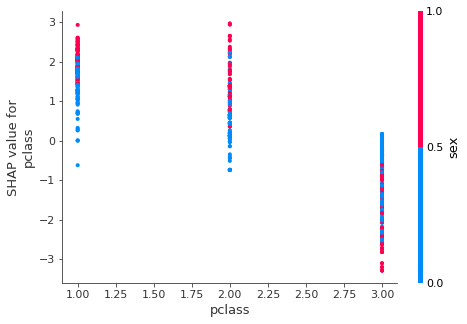

In [18]:
# what is the relationship between female and passenger class in defining SHAP value?
feature_to_plot = "pclass"
feature_to_interact = "sex"

# The first argument is the name/index of the feature we want to plot
# The second argument is the matrix of SHAP values (it is the same shape as the data matrix)
# The third argument is the data matrix (a pandas dataframe or numpy array)
shap.dependence_plot(feature_to_plot, shap_values[1], X_split, display_features=X_split, interaction_index=feature_to_interact)

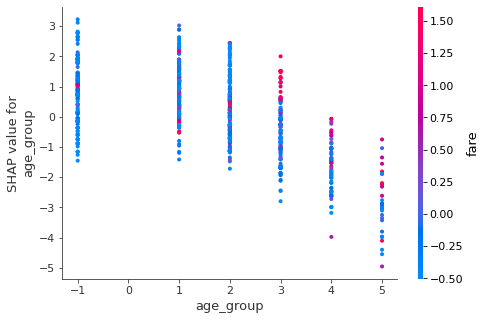

In [19]:
feature_to_plot = "age_group"
feature_to_interact = "fare"
shap.dependence_plot(feature_to_plot, shap_values[1], X_split, display_features=X_split, interaction_index=feature_to_interact)


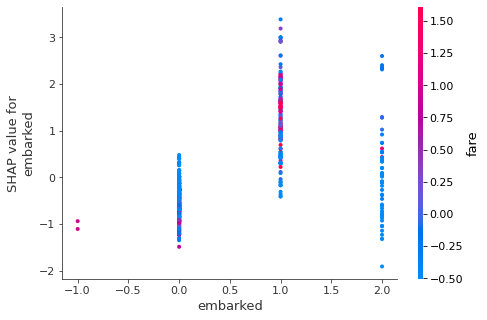

In [20]:
feature_to_plot = "embarked"
feature_to_interact = "fare"
shap.dependence_plot(feature_to_plot, shap_values[1], X_split, display_features=X_split, interaction_index=feature_to_interact)

### References

SHAP explainer source code: https://github.com/slundberg/shap/blob/master/shap/explainers/_tree.py  
SHAP dependence plot: https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html 


# End